# Program description

- This program merges electoral data with worker level data and classifies each candidate as STEM or Non-STEM

# TODO

# Setting the ambience

In [812]:
import pandas as pd
import re
import pyodbc
import time
import numpy as np
import warnings
from unidecode import unidecode
warnings.simplefilter("ignore") # disable warnings

create_electoral_data_dir = "C:/Users/GabrielCaserDosPasso/Documents/RAIS/1_create_electoral_data/output/data/"
work_dir                  = "C:/Users/GabrielCaserDosPasso/Documents/RAIS/2_create_occupation_data/"
output_dir                = "C:/Users/GabrielCaserDosPasso/Documents/RAIS/2_create_occupation_data/output/"

# Oppening dataset with most voted candidates

In [813]:
df_candidates = pd.read_csv(create_electoral_data_dir + "df_candidatos_2020_clean.csv", sep = ";", dtype = str)

# Deffining STEM professions

In [815]:
cbos_stem = "1223 1236 1237 1413 1425 1426 2011 2012 2021 2030 2031 2032 2033 2034 2111 2112 2122 2123 2124 2131 2132 2133 2134 2140 2142 2143 2144 2145 2146 2147 2148 2149 2211 2212 2221 2222 2341 2342 2343 2344 2513 3001 3003 3011 3012 3111 3112 3115 3121 3122 3123 3161 3171 3172 3180 3181 3182 3183 3185 3186 3187 3201 3212 3253 3951"

- source: Machado et all 2021

# Deffining years and states of interest

In [816]:
anos =[2003]
for i in range(2018 - anos[0]): # mudar depois
    anos.append(anos[-1] + 1)

In [817]:
estados = list(df_candidates.sigla_uf.unique())
#estados = ["SP"]

# Creating list of IDs to search in RAIS

In [818]:
cpfs_rdd = tuple(df_candidates.cpf.unique())

In [819]:
len(cpfs_rdd)

13585

# Login into RAIS server

In [820]:
server = 'sql-sigilo-eastus-prod.71d5dd223a40.database.windows.net'

database = 'RAIS'

port= '1433'

username = 'GabrielCP3'

password = '@VN1ai2GG3as4'

driver= '{SQL Server}'

cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+ password)

cursor = cnxn.cursor()

## Creating function that downloads RAIS data

In [821]:
df = pd.DataFrame()

In [822]:
def rais(ano,estado):
    global df
   
    if ano >= 2011:
        consulta_1 = """ SELECT
                    a.CPF cpf,
                    a.[PIS] pis,
                    a.[Nome Trabalhador] nome,
                    a.[Município] id_municipio,
                    a.[CNPJ Raiz] cnpj_raiz,
                    a.[CBO Ocupação 2002] cbo_2002,
                    a.[Vl Remun Dezembro Nom] rem_dez,
                    a.[Data Admissão Declarada] data_adm,
                    a.[Tempo Emprego] tenure,
                    a.[Vínculo Ativo 31 12] vinc_ativ3112,
                    a.[Qtd Hora Contr] hours
                    FROM dbo.{}{}ID a
                    WHERE a.[Vínculo Ativo 31 12] != '0'
                    AND a.[Vínculo Ativo 31 12] != '0'
                    AND a.[Vínculo Ativo 31 12] != ' 0'
                    AND a.[Vínculo Ativo 31 12] != 0
                    AND a.[CPF] IN {}
                   """.format(estado,ano,cpfs_rdd)
        
        df_provisorio = pd.read_sql(consulta_1,  cnxn)
        
        df_provisorio["Ano"] = ano
        df_provisorio["Estado"] = estado
        
        df_provisorio['cpf'] = df_provisorio['cpf'].str.strip()
    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 1') |
                      (df_provisorio['vinc_ativ3112'] == '1')  |
                      (df_provisorio['vinc_ativ3112'] == 'True'), 'vinc_ativ3112'] = 1
    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 0') |
                      (df_provisorio['vinc_ativ3112'] == '0')  |
                      (df_provisorio['vinc_ativ3112'] == 'False'),'vinc_ativ3112'] = 0
           
        df = pd.concat([df, df_provisorio])
           
        print(f"foi criado um df de tamanho {len(df)}")

    elif ano >= 2006:
        
        consulta_1 = """ SELECT
                        a.CPF cpf,
                        a.[PIS] pis,
                        a.[NOME] nome,
                        a.[MUNICIPIO] id_municipio,
                        a.[RADIC CNPJ] cnpj_raiz,
                        a.[OCUP 2002] cbo_2002,
                        a.[REM DEZEMBRO] rem_dez,
                        a.[DT ADMISSAO] data_adm,
                        a.[TEMP EMPR] tenure,
                        a.[EMP EM 31 12] vinc_ativ3112,
                        a.[HORAS CONTR] hours
                        FROM dbo.{}{}ID a
                        WHERE a.[EMP EM 31 12] != '0'
                        AND a.[EMP EM 31 12] != '0'
                        AND a.[EMP EM 31 12] != ' 0'
                        AND a.[EMP EM 31 12] != 0
                        AND a.[CPF] IN {}
                        """.format(estado,ano,cpfs_rdd)
        
        df_provisorio = pd.read_sql(consulta_1,  cnxn)
        
        df_provisorio["Ano"] = ano
        df_provisorio["Estado"] = estado
        
        df_provisorio['cpf'] = df_provisorio['cpf'].str.strip()

    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 1') |
                      (df_provisorio['vinc_ativ3112'] == '1')  |
                      (df_provisorio['vinc_ativ3112'] == 'True'), 'vinc_ativ3112'] = 1
    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 0') |
                      (df_provisorio['vinc_ativ3112'] == '0')  |
                      (df_provisorio['vinc_ativ3112'] == 'False'),'vinc_ativ3112'] = 0
           
        df = pd.concat([df, df_provisorio])
           
        print(f"foi criado um df de tamanho {len(df)}")
        
        
    else: # 2003 until 2005
        
        consulta_1 = """ SELECT
                        a.CPF cpf,
                        a.[PIS] pis,
                        a.[NOME] nome,
                        a.[MUNICIPIO] id_municipio,
                        a.[RADIC CNPJ] cnpj_raiz,
                        a.[OCUP 2002] cbo_2002,
                        a.[REM DEZEMBRO] rem_dez,
                        a.[DT ADMISSAO] data_adm,
                        a.[TEMP EMPR] tenure,
                        a.[EMP EM 31 12] vinc_ativ3112,
                        a.[HORAS CONTR] hours
                        FROM dbo.{}{}ID a
                        WHERE a.[EMP EM 31 12] != '0'
                        AND a.[EMP EM 31 12] != '0'
                        AND a.[EMP EM 31 12] != ' 0'
                        AND a.[EMP EM 31 12] != 0
                        AND a.[CPF] IN {}
                        """.format(estado,ano,cpfs_rdd)
        df_provisorio = pd.read_sql(consulta_1,  cnxn)
        
        df_provisorio["Ano"] = ano
        df_provisorio["Estado"] = estado
        
        df_provisorio['cpf'] = df_provisorio['cpf'].str.strip()

    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 1') |
                      (df_provisorio['vinc_ativ3112'] == '1')  |
                      (df_provisorio['vinc_ativ3112'] == 'True'), 'vinc_ativ3112'] = 1
    
        df_provisorio.loc[(df_provisorio['vinc_ativ3112'] == ' 0') |
                      (df_provisorio['vinc_ativ3112'] == '0')  |
                      (df_provisorio['vinc_ativ3112'] == 'False'),'vinc_ativ3112'] = 0
           
        df = pd.concat([df, df_provisorio])
           
        print(f"foi criado um df de tamanho {len(df)}")

In [823]:
start_time = time.time()

for x in estados:
    for i in anos:
        rais(i,x)
    
print("My program took", time.time() - start_time, "to run")

foi criado um df de tamanho 21
foi criado um df de tamanho 124
foi criado um df de tamanho 256
foi criado um df de tamanho 388
foi criado um df de tamanho 516
foi criado um df de tamanho 699
foi criado um df de tamanho 905
foi criado um df de tamanho 1110
foi criado um df de tamanho 1339
foi criado um df de tamanho 1536
foi criado um df de tamanho 1753
foi criado um df de tamanho 1947
foi criado um df de tamanho 2148
foi criado um df de tamanho 2307
foi criado um df de tamanho 2479
foi criado um df de tamanho 2670
foi criado um df de tamanho 2757
foi criado um df de tamanho 3180
foi criado um df de tamanho 3670
foi criado um df de tamanho 4162
foi criado um df de tamanho 4674
foi criado um df de tamanho 5398
foi criado um df de tamanho 6231
foi criado um df de tamanho 7006
foi criado um df de tamanho 7775
foi criado um df de tamanho 8447
foi criado um df de tamanho 9227
foi criado um df de tamanho 9963
foi criado um df de tamanho 10707
foi criado um df de tamanho 11273
foi criado um df

foi criado um df de tamanho 60145
foi criado um df de tamanho 60193
foi criado um df de tamanho 60282
foi criado um df de tamanho 60390
foi criado um df de tamanho 60494
foi criado um df de tamanho 60613
foi criado um df de tamanho 60703
foi criado um df de tamanho 60815
foi criado um df de tamanho 60909
foi criado um df de tamanho 61005
foi criado um df de tamanho 61079
foi criado um df de tamanho 61158
foi criado um df de tamanho 61226
foi criado um df de tamanho 61238
foi criado um df de tamanho 61369
foi criado um df de tamanho 61493
foi criado um df de tamanho 61627
foi criado um df de tamanho 61767
foi criado um df de tamanho 62001
foi criado um df de tamanho 62278
foi criado um df de tamanho 62546
foi criado um df de tamanho 62823
foi criado um df de tamanho 63097
foi criado um df de tamanho 63368
foi criado um df de tamanho 63634
foi criado um df de tamanho 63891
foi criado um df de tamanho 64092
foi criado um df de tamanho 64311
foi criado um df de tamanho 64499
foi criado um 

# Cleaning RAIS data

In [824]:
df = df.drop(columns = "rem_dez")

In [825]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80637 entries, 0 to 27
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cpf            80637 non-null  object
 1   pis            80637 non-null  object
 2   nome           80637 non-null  object
 3   id_municipio   80637 non-null  object
 4   cnpj_raiz      80637 non-null  object
 5   cbo_2002       80637 non-null  object
 6   data_adm       80637 non-null  object
 7   tenure         80637 non-null  object
 8   vinc_ativ3112  80637 non-null  object
 9   hours          80637 non-null  object
 10  Ano            80637 non-null  int64 
 11  Estado         80637 non-null  object
dtypes: int64(1), object(11)
memory usage: 8.0+ MB


In [826]:
df = df.drop_duplicates()

In [827]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80614 entries, 0 to 27
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cpf            80614 non-null  object
 1   pis            80614 non-null  object
 2   nome           80614 non-null  object
 3   id_municipio   80614 non-null  object
 4   cnpj_raiz      80614 non-null  object
 5   cbo_2002       80614 non-null  object
 6   data_adm       80614 non-null  object
 7   tenure         80614 non-null  object
 8   vinc_ativ3112  80614 non-null  object
 9   hours          80614 non-null  object
 10  Ano            80614 non-null  int64 
 11  Estado         80614 non-null  object
dtypes: int64(1), object(11)
memory usage: 8.0+ MB


In [828]:
# keeping only numbers in the cbo_2002 variable
df['cbo_2002_original'] = df['cbo_2002']
df['cbo_2002'] = df['cbo_2002'].str.extract('(\d+)').astype(str)

In [829]:
df["pis"] = df["pis"].str.strip() #removing leading and ending spaces

In [830]:
df["data_adm"] = df["data_adm"].str.strip() #removing leading and ending spaces
df["cbo_2002"] = df["cbo_2002"].str.strip() #removing leading and ending spaces

# Creating variable "tenure" that measures how many months someone worked in a STEM occupation

In [831]:
lista = list(df["tenure"])

In [832]:
# replacing "," for "."
coluna = []

for i in lista:
    if ',' in str(i).lower():  
        coluna.append(i.replace(',', '.'))
    else:
        coluna.append(i)
        
df["tenure"] = coluna

In [833]:
# changing variable types
df["tenure"] = df['tenure'].astype(float)
#df["tenure"] = df['tenure'].astype(int)
#df['data_adm'] = df['data_adm'].astype(int)


In [834]:
df['cnpj_raiz'] = df['cnpj_raiz'].astype(str).str.zfill(8) # filling cnpj with leading 0 until it reaches 8 characters
df['cbo_2002'] = df['cbo_2002'].astype(str).str.zfill(6) # filling cbo with leading 0 until it reaches 6 characters
df['data_adm'] = df['data_adm'].astype(str).str.zfill(8) # filling cbo with leading 0 until it reaches 8 characters

df['data_adm'] = pd.to_datetime(df['data_adm'], format = '%d%m%Y') # changing do date time type

## Keeping CPFs with more than one PIS only for those who match names with TCE dataset

In [835]:
df["n_pis"] = df.groupby('cpf')['pis'].transform('nunique') # number of unique PIS per cpf

In [836]:
# cleaning names
df["nome"] = df["nome"].str.strip() #removing leading and ending spaces
df["nome"] = df["nome"].apply(unidecode) # removing accents
df["nome"] = df["nome"].str.lower() #using lower letters
df["first_name"] = df["nome"].str.split().str[0] #creating first name variable
df["last_name"] = df["nome"].str.split().str[-1] #creating last name variable

# cleaning names from TSE dataset
df_candidates["nome"] = df_candidates["nome"].str.strip() #removing leading and ending spaces
df_candidates["nome"] = df_candidates["nome"].apply(unidecode) #removing accents
df_candidates["nome"] = df_candidates["nome"].str.lower() #using lower letters
df_candidates["first_name"] = df_candidates["nome"].str.split().str[0] #creating first name variable
df_candidates["last_name"] = df_candidates["nome"].str.split().str[-1] #creating last name variable

In [837]:
df = pd.merge(df, df_candidates[['cpf','nome','first_name','last_name','id_municipio']], how = "outer", on = "cpf", indicator = True, validate = "many_to_one", suffixes = ('_rais', '_tse') , )

In [838]:
df._merge.value_counts()

both          80614
right_only     4036
left_only         0
Name: _merge, dtype: int64

- 4036 of 13585 candidates did not appeared in RAIS

In [839]:
df = df[df["_merge"] != "right_only"] # dropping TSE candidates that were not in RAIS

In [840]:
df['equal_names'] = (df["first_name_rais"] == df["first_name_tse"]) # creating dummy that indicates wether the name in RAIS is the same as the name in TSE 

In [841]:
df = df[(df['n_pis'] == 1) | df['equal_names'] == True] # keeping only observations in RAIS which have only one PIS or have the same first_name in RAIS and TSE datasets 

In [842]:
df = df.drop(columns = ['equal_names', '_merge', 'id_municipio_tse', 'last_name_tse', 'first_name_tse', 'nome_tse', 'last_name_rais', 'first_name_rais'])

In [843]:
df["n_pis_new"] = df.groupby('cpf')['pis'].transform('nunique')

In [844]:
df.describe()

,tenure,Ano,n_pis,n_pis_new
count,80082.000000,80082.000000,80082.000000,80082.000000
mean,105.539399,2011.193402,1.146625,1.126196
std,108.653309,4.102809,0.864160,0.369250
min,0.000000,2003.000000,1.000000,1.000000
25%,20.900000,2008.000000,1.000000,1.000000
50%,59.900000,2011.000000,1.000000,1.000000
75%,164.900000,2015.000000,1.000000,1.000000
max,592.900024,2018.000000,70.000000,6.000000


- there are still a few CPFs with multiple PIS. But now they seem to be the same person because they have the same name

## Creating identificator of contracts per person

In [845]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80082 entries, 0 to 80613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cpf                80082 non-null  object        
 1   pis                80082 non-null  object        
 2   nome_rais          80082 non-null  object        
 3   id_municipio_rais  80082 non-null  object        
 4   cnpj_raiz          80082 non-null  object        
 5   cbo_2002           80082 non-null  object        
 6   data_adm           80082 non-null  datetime64[ns]
 7   tenure             80082 non-null  float64       
 8   vinc_ativ3112      80082 non-null  object        
 9   hours              80082 non-null  object        
 10  Ano                80082 non-null  float64       
 11  Estado             80082 non-null  object        
 12  cbo_2002_original  80082 non-null  object        
 13  n_pis              80082 non-null  float64       
 14  n_pis_

In [846]:
df["count"] = df.groupby(['cpf','data_adm',"cbo_2002"])["cbo_2002"].transform('count') # this variable indicates that person p is working in a contract c

In [847]:
df["contract_id"] = df.groupby(['cpf','data_adm',"cbo_2002","cnpj_raiz"]).ngroup() # this variable indicates that person p is working in a contract c

In [848]:
df["n_contracts"] = df.groupby('cpf')['contract_id'].transform('nunique') # this variable indicates the number of different contracts that each person had
df["n_contracts_year"] = df.groupby(['cpf','Ano'])['contract_id'].transform('nunique') # the same but per year

In [849]:
df.describe()

,tenure,Ano,n_pis,n_pis_new,count,contract_id,n_contracts,n_contracts_year
count,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000
mean,105.539399,2011.193402,1.146625,1.126196,5.651707,14723.256837,4.538111,1.404573
std,108.653309,4.102809,0.864160,0.369250,4.166271,8337.653493,3.412618,0.754463
min,0.000000,2003.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,20.900000,2008.000000,1.000000,1.000000,2.000000,7682.250000,2.000000,1.000000
50%,59.900000,2011.000000,1.000000,1.000000,5.000000,14758.000000,4.000000,1.000000
75%,164.900000,2015.000000,1.000000,1.000000,9.000000,21813.000000,6.000000,2.000000
max,592.900024,2018.000000,70.000000,6.000000,23.000000,29266.000000,34.000000,9.000000


## Creating "contract_tenure" 

- it calculates the total time that a worker was in a specific contract

In [850]:
df["contract_first_year"] = df.groupby(['contract_id'])["Ano"].transform('min') # first year a contract appears in Rais
df["contract_last_year"] = df.groupby(['contract_id'])["Ano"].transform('max') # last year a contract appears in Rais

In [851]:
df["contract_first_year_tenure"] = df[(df["contract_first_year"] == df["Ano"])]["tenure"] # getting the inital value of tenure per contract
df["contract_last_year_tenure"] = df[(df["contract_last_year"] == df["Ano"])]["tenure"] # getting the final value of tenure per contract

In [852]:
df["contract_first_year_tenure"] = df.groupby(['contract_id'])["contract_first_year_tenure"].transform('sum') # coping this value to all the observations of that contract
df["contract_last_year_tenure"] = df.groupby(['contract_id'])["contract_last_year_tenure"].transform('sum') # coping this value to all the observations of that contract

In [853]:
df["contract_tenure"] = df["contract_last_year_tenure"] - df["contract_first_year_tenure"]

In [854]:
df.loc[(df["contract_first_year"] == df["contract_last_year"]) & (df["contract_first_year_tenure"] <= 12), "contract_tenure"] = df["contract_first_year_tenure"] # using the first years' tenure all the total value if the contract only has one year and the tenure in the first yera is less or equal to 12
df.loc[(df["contract_first_year"] == df["contract_last_year"]) & (df["contract_first_year_tenure"] > 12), "contract_tenure"] = 12 # replacing the total duration of a contract for 12 when the contract only appeared one year and the tenure of the first contract was bigger than 12. 

- The last replacement was necessary, because we do not observe before 2003. Therefore, since tenure does not reset when a worker change its' occupation inside the same company, a worker could have been working in a non-STEM job for 120 months, but only in the last 12 months he worked in a STEM job. Therefore, we would be superestimating his STEM experience. When we change this value to 12, it means that we're only considering his experience from 2003 until the yera of his election 

In [855]:
df.describe()

,tenure,Ano,n_pis,n_pis_new,count,contract_id,n_contracts,n_contracts_year,contract_first_year,contract_last_year,contract_first_year_tenure,contract_last_year_tenure,contract_tenure
count,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000,80082.000000
mean,105.539399,2011.193402,1.146625,1.126196,5.651707,14723.256837,4.538111,1.404573,2008.780088,2013.605117,76.582229,134.492424,59.567819
std,108.653309,4.102809,0.864160,0.369250,4.166271,8337.653493,3.412618,0.754463,3.964828,4.270065,95.456042,120.528301,50.643400
min,0.000000,2003.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2003.000000,2003.000000,0.000000,0.000000,-111.600000
25%,20.900000,2008.000000,1.000000,1.000000,2.000000,7682.250000,2.000000,1.000000,2005.000000,2010.000000,9.900000,34.900000,12.000000
50%,59.900000,2011.000000,1.000000,1.000000,5.000000,14758.000000,4.000000,1.000000,2008.000000,2015.000000,25.000000,95.900000,47.999994
75%,164.900000,2015.000000,1.000000,1.000000,9.000000,21813.000000,6.000000,2.000000,2012.000000,2018.000000,119.450001,204.399994,96.000000
max,592.900024,2018.000000,70.000000,6.000000,23.000000,29266.000000,34.000000,9.000000,2018.000000,2018.000000,557.900024,592.900024,187.999994


- Negatives in min value for contract_tenure is strange, but I'll ignore it for now since it does not happen for STEM occupations

# Classifing occupations as STEM

In [856]:
df["stem_job"] = df["cbo_2002"].apply(lambda x: 1 if x[0:4] in cbos_stem else 0) # using the list from Machado(2021) to classify each occupation as a stem_job

## Keeping only last year of each contract

In [857]:
last_year_contract = df.groupby(['contract_id'])['Ano'].idxmax()# creating a dataset that keeps only the last year of a contract c from person p 
df = df.loc[last_year_contract]

## Saving

In [858]:
df.to_csv(output_dir + 'data/mayors_jobs_2020.csv', sep = ",", index = False, encoding = "utf-8-sig")

# Keeping only STEM contracts

In [859]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29267 entries, 55163 to 27506
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cpf                         29267 non-null  object        
 1   pis                         29267 non-null  object        
 2   nome_rais                   29267 non-null  object        
 3   id_municipio_rais           29267 non-null  object        
 4   cnpj_raiz                   29267 non-null  object        
 5   cbo_2002                    29267 non-null  object        
 6   data_adm                    29267 non-null  datetime64[ns]
 7   tenure                      29267 non-null  float64       
 8   vinc_ativ3112               29267 non-null  object        
 9   hours                       29267 non-null  object        
 10  Ano                         29267 non-null  float64       
 11  Estado                      29267 non-null  object

In [860]:
df = df.query("stem_job == 1")

In [861]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 42770 to 5515
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cpf                         772 non-null    object        
 1   pis                         772 non-null    object        
 2   nome_rais                   772 non-null    object        
 3   id_municipio_rais           772 non-null    object        
 4   cnpj_raiz                   772 non-null    object        
 5   cbo_2002                    772 non-null    object        
 6   data_adm                    772 non-null    datetime64[ns]
 7   tenure                      772 non-null    float64       
 8   vinc_ativ3112               772 non-null    object        
 9   hours                       772 non-null    object        
 10  Ano                         772 non-null    float64       
 11  Estado                      772 non-null    object   

## Keeping only one contract per year

In [862]:
df = df.groupby(['cpf']).apply(lambda x: x.loc[x['contract_tenure'].idxmax()]) # for person p at year y keeps the contract with the biggest tenure
df = df.reset_index(drop = True)

In [863]:
df['hours'] = df['hours'].astype(float)

In [864]:
# in case there are contracts with the same number of tenure, keep the one with biggest hours contracted
df = df.groupby(['cpf']).apply(lambda x: x.loc[x['hours'].idxmax()]) # for person p at year y keeps the contract with the biggest hours
df = df.reset_index(drop = True)

In [865]:
# In case person p at year y has more than one contract with the same number of tenure and hours, we keep one of them ramdomly
df = df.groupby("cpf").apply(lambda x: x.sample(1)) # group by ID and select a random row from each ID
df.reset_index(drop = True, inplace = True)

- Duplicates were happening because we tried to keep only the occupation with the highest number of months that a person worked, there are some people that worked the same amount in different occupations. Therefore we'll keep one of the duplicated choosing it randomly  

In [866]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cpf                         515 non-null    object        
 1   pis                         515 non-null    object        
 2   nome_rais                   515 non-null    object        
 3   id_municipio_rais           515 non-null    object        
 4   cnpj_raiz                   515 non-null    object        
 5   cbo_2002                    515 non-null    object        
 6   data_adm                    515 non-null    datetime64[ns]
 7   tenure                      515 non-null    float64       
 8   vinc_ativ3112               515 non-null    object        
 9   hours                       515 non-null    float64       
 10  Ano                         515 non-null    float64       
 11  Estado                      515 non-null    object        

In [867]:
df.describe()

,tenure,hours,Ano,n_pis,n_pis_new,count,contract_id,n_contracts,n_contracts_year,contract_first_year,contract_last_year,contract_first_year_tenure,contract_last_year_tenure,contract_tenure,stem_job
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.0
mean,121.365048,35.763107,2011.755340,1.122330,1.100971,3.871845,14513.930097,4.627184,1.363107,2008.566990,2011.755340,83.096505,121.365048,41.487378,1.0
std,123.292450,10.196618,4.828815,0.402553,0.320352,3.618355,8189.222425,3.080129,0.634757,4.325843,4.828815,102.886606,123.292450,47.309276,0.0
min,0.900000,1.000000,2003.000000,1.000000,1.000000,1.000000,103.000000,1.000000,1.000000,2003.000000,2003.000000,0.400000,0.900000,0.900000,1.0
25%,20.200000,30.000000,2007.000000,1.000000,1.000000,1.000000,7429.500000,2.000000,1.000000,2005.000000,2007.000000,8.600000,20.200000,12.000000,1.0
50%,76.900000,40.000000,2012.000000,1.000000,1.000000,2.000000,13900.000000,4.000000,1.000000,2008.000000,2012.000000,27.800000,76.900000,12.000000,1.0
75%,195.500000,44.000000,2017.000000,1.000000,1.000000,6.000000,21243.500000,6.000000,2.000000,2012.000000,2017.000000,140.700000,195.500000,60.000001,1.0
max,537.900000,44.000000,2018.000000,6.000000,3.000000,16.000000,29214.000000,29.000000,4.000000,2018.000000,2018.000000,465.900000,537.900000,168.100012,1.0


## Creating column "cbo_max" that indicates the STEM job with more tenure

In [868]:
df["total_tenure"] = df.groupby(['cpf'])['contract_tenure'].transform('sum') # total months in STEM occupations per person 

In [869]:
df.describe()

,tenure,hours,Ano,n_pis,n_pis_new,count,contract_id,n_contracts,n_contracts_year,contract_first_year,contract_last_year,contract_first_year_tenure,contract_last_year_tenure,contract_tenure,stem_job,total_tenure
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.0,515.000000
mean,121.365048,35.763107,2011.755340,1.122330,1.100971,3.871845,14513.930097,4.627184,1.363107,2008.566990,2011.755340,83.096505,121.365048,41.487378,1.0,41.487378
std,123.292450,10.196618,4.828815,0.402553,0.320352,3.618355,8189.222425,3.080129,0.634757,4.325843,4.828815,102.886606,123.292450,47.309276,0.0,47.309276
min,0.900000,1.000000,2003.000000,1.000000,1.000000,1.000000,103.000000,1.000000,1.000000,2003.000000,2003.000000,0.400000,0.900000,0.900000,1.0,0.900000
25%,20.200000,30.000000,2007.000000,1.000000,1.000000,1.000000,7429.500000,2.000000,1.000000,2005.000000,2007.000000,8.600000,20.200000,12.000000,1.0,12.000000
50%,76.900000,40.000000,2012.000000,1.000000,1.000000,2.000000,13900.000000,4.000000,1.000000,2008.000000,2012.000000,27.800000,76.900000,12.000000,1.0,12.000000
75%,195.500000,44.000000,2017.000000,1.000000,1.000000,6.000000,21243.500000,6.000000,2.000000,2012.000000,2017.000000,140.700000,195.500000,60.000001,1.0,60.000001
max,537.900000,44.000000,2018.000000,6.000000,3.000000,16.000000,29214.000000,29.000000,4.000000,2018.000000,2018.000000,465.900000,537.900000,168.100012,1.0,168.100012


In [870]:
df = df.rename(columns = {"tenure": "tenure_rais"})

In [871]:
df = df.rename(columns = {"total_tenure": "tenure"})

In [872]:
df["max_contract_tenure"] = df.groupby(['cpf'])['contract_tenure'].transform('max') # creates a variable with the highest number of months that a person worked 

In [873]:
df = df[(df["max_contract_tenure"] == df["contract_tenure"])] # keeping only the occupation with the highest number of months that a person worked  

- é possível que as duplicatas estejam vindo daqui. Se um cara trabalhou o mesmo tempo em duas profissões, vai dar duplicado.
- uma alternativa é manter apenas a profissão com o salário mais alto no caso de duplicata.

In [875]:
# droping acessory variables
df = df.drop(columns = ['Ano', 'contract_first_year_tenure', 'n_contracts_year', 'contract_last_year_tenure', 'contract_first_year','contract_last_year', 'contract_tenure', 'max_contract_tenure', 'contract_id', 'count', 'n_pis', 'cbo_2002_original', 'cnpj_raiz'])

In [876]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 514
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cpf                515 non-null    object        
 1   pis                515 non-null    object        
 2   nome_rais          515 non-null    object        
 3   id_municipio_rais  515 non-null    object        
 4   cbo_2002           515 non-null    object        
 5   data_adm           515 non-null    datetime64[ns]
 6   tenure_rais        515 non-null    float64       
 7   vinc_ativ3112      515 non-null    object        
 8   hours              515 non-null    float64       
 9   Estado             515 non-null    object        
 10  n_pis_new          515 non-null    int64         
 11  n_contracts        515 non-null    int64         
 12  stem_job           515 non-null    int64         
 13  tenure             515 non-null    float64       
dtypes: datetim

## Merging electoral data (df_canidates) with STEM mayors' occupational data (df_tenure_only_stem) 

In [877]:
df = pd.merge(df, df_candidates, how = "outer", on = "cpf", indicator = True, validate = "one_to_one")

In [878]:
df["stem_job"].fillna(0, inplace=True) # classifies all candidates that didn't have a formal STEM job as a Non-STEM candidate

In [879]:
df["tenure"].fillna(0, inplace = True) # gives 0 of exposure intensity to Non-STEM candidates

In [880]:
df.describe()

,tenure_rais,hours,n_pis_new,n_contracts,stem_job,tenure
count,515.000000,515.000000,515.000000,515.000000,13585.000000,13585.000000
mean,121.365048,35.763107,1.100971,4.627184,0.037909,1.572764
std,123.292450,10.196618,0.320352,3.080129,0.190984,12.143727
min,0.900000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.200000,30.000000,1.000000,2.000000,0.000000,0.000000
50%,76.900000,40.000000,1.000000,4.000000,0.000000,0.000000
75%,195.500000,44.000000,1.000000,6.000000,0.000000,0.000000
max,537.900000,44.000000,3.000000,29.000000,1.000000,168.100012


# Creating variable "rdd_stem_won" that indicates whether the STEM candidates won 

In [881]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13585 entries, 0 to 13584
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cpf                13585 non-null  object        
 1   pis                515 non-null    object        
 2   nome_rais          515 non-null    object        
 3   id_municipio_rais  515 non-null    object        
 4   cbo_2002           515 non-null    object        
 5   data_adm           515 non-null    datetime64[ns]
 6   tenure_rais        515 non-null    float64       
 7   vinc_ativ3112      515 non-null    object        
 8   hours              515 non-null    float64       
 9   Estado             515 non-null    object        
 10  n_pis_new          515 non-null    float64       
 11  n_contracts        515 non-null    float64       
 12  stem_job           13585 non-null  float64       
 13  tenure             13585 non-null  float64       
 14  ano   

In [882]:
teste = pd.DataFrame(df.groupby(["id_municipio"]).stem_job.sum())

In [883]:
teste.rename(columns = {"stem_job": "n_stem_candidates"}, inplace = True)

In [884]:
df = df.drop(columns = "_merge")

In [885]:
df = pd.merge(df, teste, how = "left", on = "id_municipio", indicator = True)

In [886]:
df.n_stem_candidates.value_counts()

0.0    12241
1.0     1279
2.0       65
Name: n_stem_candidates, dtype: int64

In [887]:
df.query("resultado == 'eleito' & stem_job == 1").shape

(211, 38)

In [888]:
df["stem_won"] = ((df["resultado"] == 'eleito') & (df["stem_job"] == 1)).astype(int) # creates dummy

# Droping stem candidates whose election was invalidated

In [889]:
df[df["stem_job"] == 1].situacao.value_counts()

deferido                508
deferido com recurso      6
cassado com recurso       1
Name: situacao, dtype: int64

# Saving

In [890]:
# droping variables that we won't use
df = df.drop(columns = ['_merge', 'data_adm'])

In [891]:
# changing types
df.ano = df.ano.astype(int)
df.idade = df.idade.astype(float)
df.dif_votos_2_lugar = df.dif_votos_2_lugar.astype(float)
df.dif_votos_3_lugar = df.dif_votos_3_lugar.astype(float)

In [892]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13585 entries, 0 to 13584
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cpf                13585 non-null  object 
 1   pis                515 non-null    object 
 2   nome_rais          515 non-null    object 
 3   id_municipio_rais  515 non-null    object 
 4   cbo_2002           515 non-null    object 
 5   tenure_rais        515 non-null    float64
 6   vinc_ativ3112      515 non-null    object 
 7   hours              515 non-null    float64
 8   Estado             515 non-null    object 
 9   n_pis_new          515 non-null    float64
 10  n_contracts        515 non-null    float64
 11  stem_job           13585 non-null  float64
 12  tenure             13585 non-null  float64
 13  ano                13585 non-null  int32  
 14  tipo_eleicao       13585 non-null  object 
 15  sigla_uf           13585 non-null  object 
 16  id_municipio       135

- cbo_2002 has a lower number of observations because we only got information on STEM occupations
- dif_votos_3_lugar has a lower number of obs because we consider it missing when municipalities had less than 3 candidates

In [893]:
df.describe()

,tenure_rais,hours,n_pis_new,n_contracts,stem_job,tenure,ano,idade,dif_votos_2_lugar,dif_votos_3_lugar,n_stem_candidates,stem_won
count,515.000000,515.000000,515.000000,515.000000,13585.000000,13585.000000,13585.0,13585.000000,13585.000000,9337.000000,13585.000000,13585.000000
mean,121.365048,35.763107,1.100971,4.627184,0.037909,1.572764,2020.0,49.763563,0.178352,0.393450,0.103717,0.015532
std,123.292450,10.196618,0.320352,3.080129,0.190984,12.143727,0.0,11.006271,0.171953,0.174863,0.320214,0.123660
min,0.900000,1.000000,1.000000,1.000000,0.000000,0.000000,2020.0,21.000000,0.000000,0.007768,0.000000,0.000000
25%,20.200000,30.000000,1.000000,2.000000,0.000000,0.000000,2020.0,42.000000,0.056080,0.259222,0.000000,0.000000
50%,76.900000,40.000000,1.000000,4.000000,0.000000,0.000000,2020.0,50.000000,0.125111,0.416296,0.000000,0.000000
75%,195.500000,44.000000,1.000000,6.000000,0.000000,0.000000,2020.0,57.000000,0.243022,0.516148,0.000000,0.000000
max,537.900000,44.000000,3.000000,29.000000,1.000000,168.100012,2020.0,95.000000,0.996139,0.986481,2.000000,1.000000


In [894]:
df.to_csv(output_dir + 'data/base_rdd_covid_stem_2020.csv', sep = ",", index = False, encoding = "utf-8-sig")

In [895]:
teste = df[df['stem_job'] == 1]

<AxesSubplot:xlabel='tenure', ylabel='Count'>

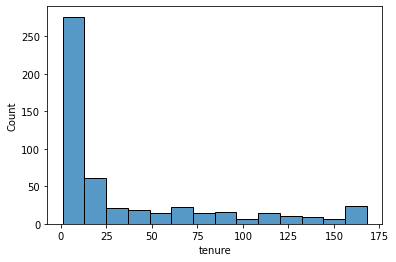

In [898]:
sns.histplot(teste['tenure'])